In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import time
import re
import nltk
import math
import os
import matplotlib.pyplot as plt
import sklearn.metrics

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import linear_model
from sklearn.linear_model import Perceptron

from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import PassiveAggressiveClassifier

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import pickle

%matplotlib inline


## Load csv files

In [2]:

df_gol = pd.read_csv('uniprot-golgi-unreviewed.csv')
df_mito = pd.read_csv('uniprot-mito-reviewed2.csv')
df_pm = pd.read_csv('uniprot-pm-reviewed.csv')
df_cyto = pd.read_csv('uniprot-cytoplasm-20K.csv')
df_ER = pd.read_csv('uniprot-ER-136K.csv')
df_nuc = pd.read_csv('uniprot-nucleus-reviewed.csv')
df_lyso = pd.read_csv('uniprot-lysosome-unreviewed.csv')

In [3]:
df_gol2 = df_gol.sample(frac=0.33)
df_ER2 = df_ER.sample(frac=0.27)
df_nuc2 = df_nuc.sample(frac=0.5)
df_lyso2 = df_lyso.sample(frac=0.5)

In [4]:
proteins = pd.concat([df_mito,df_pm,df_cyto,df_gol2,df_ER2,df_nuc2,df_lyso2])
proteins.head()

,name,sequence,location,label
0,sp|Q9BV35|SCMC3_HUMAN,MRGSPGDAERRQRWGRLFEELDSNKDGRVDVHELRQGLARLGGGNP...,6,mitochondria
1,sp|Q6NUK1|SCMC1_HUMAN,MLRWLRDFVLPTAACQDAEQPTRYETLFQALDRNGDGVVDIGELQE...,6,mitochondria
2,sp|Q9NUT2|MITOS_HUMAN,MLVHLFRVGIRGGPFPGRLLPPLRFQTFSAVRNTWRNGKTGQLHKA...,6,mitochondria
3,sp|Q6KCM7|SCMC2_HUMAN,MLCLCLYVPVIGEAQTEFQYFESKGLPAELKSIFKLSVFIPSQEFS...,6,mitochondria
4,sp|P53230|TAM41_YEAST,MLRVSENGLRFLLKCHSTNVSMFNRLLSTQIKEGRSSIDDAGIIPD...,6,mitochondria


In [5]:
proteins.shape

(184289, 4)

In [6]:
# permute/scramble/shuffle rows of the dataframe
proteins = proteins.sample(frac=1)

In [7]:
proteins.location.value_counts()

0    33594
8    30734
7    26197
1    26015
6    24128
9    23119
3    20502
Name: location, dtype: int64

In [8]:
proteins.label.value_counts()

ER                 33594
lysosome           30734
nucleus            26197
Golgi              26015
mitochondria       24128
plasma_membrane    23119
cytoplasm          20502
Name: label, dtype: int64

In [9]:
# remove the duplicate protein sequences
proteins = proteins.drop_duplicates(subset='sequence', keep="first")

# remove nan from 'sequence' column
proteins = proteins[proteins['sequence'].notnull()]

proteins.shape

(176864, 4)

## Transform the protein sequence data with CountVectorizer to get peptide frequency. Split the data into training & test sets.

In [10]:
# Peptide count is used for analysis
peptide_size = 6
vect = CountVectorizer(min_df=1,token_pattern=r'\w{1}',ngram_range=(peptide_size,peptide_size))

In [11]:
X = vect.fit_transform(proteins.sequence)
y = proteins.location

In [12]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state =42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(141491, 21552618) (141491,)
(35373, 21552618) (35373,)


In [13]:
y_test.value_counts()

0    6516
8    6216
1    5086
7    4702
9    4487
6    4417
3    3949
Name: location, dtype: int64

In [14]:
%%time
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
# evaluate accuracy of our model on test data
print("MNB classifier Score: {:.2f}".format(mnb.score(X_test, y_test)))
print()

MNB classifier Score: 0.86

CPU times: user 13.2 s, sys: 7.99 s, total: 21.2 s
Wall time: 23.5 s


In [15]:
%%time
pac = PassiveAggressiveClassifier()
pac.fit(X_train, y_train)
# evaluate accuracy of our model on test data
print("Passive Aggressive classifier Score: {:.2f}".format(pac.score(X_test, y_test)))
print()

Passive Aggressive classifier Score: 0.87

CPU times: user 1min 49s, sys: 4.09 s, total: 1min 53s
Wall time: 1min 57s


In [16]:
%%time
pac2 = PassiveAggressiveClassifier(loss='squared_hinge')
pac2.fit(X_train, y_train)
# evaluate accuracy of our model on test data
print("Passive Aggressive classifier with squared hinge loss Score: {:.2f}".format(pac2.score(X_test, y_test)))
print()

Passive Aggressive classifier with squared hinge loss Score: 0.85

CPU times: user 1min 58s, sys: 7.38 s, total: 2min 5s
Wall time: 2min 11s


In [17]:
%%time
sgd = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
sgd.fit(X_train, y_train)
# evaluate accuracy of our model on test data
print("SGD classifier Score: {:.2f}".format(sgd.score(X_test, y_test)))
print()

SGD classifier Score: 0.87

CPU times: user 2min 45s, sys: 8.71 s, total: 2min 54s
Wall time: 3min 1s


In [18]:
%%time
per = Perceptron(tol=1e-3, random_state=0).fit(X_train,y_train)
# evaluate accuracy of our model on test data
print("Perceptron classifier Score: {:.2f}".format(per.score(X_test, y_test)))
print()

Perceptron classifier Score: 0.85

CPU times: user 4min 57s, sys: 8.93 s, total: 5min 6s
Wall time: 5min 16s


## Majority Vote Classifier

In [19]:
# three classifiers: SGD, PassiveAggressiveClassifier, MNB

clf1 = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
clf2 = PassiveAggressiveClassifier()
clf3 = MultinomialNB()

In [20]:
eclf1 = VotingClassifier(estimators=[('sgd', clf1), ('pac', clf2), ('mnb', clf3)], voting='hard')
eclf1 = eclf1.fit(X_train, y_train)
# evaluate accuracy of our model on test data
print("Majority Voting Classifier Score: {:.2f}".format(eclf1.score(X_test, y_test)))

Majority Voting Classifier Score: 0.87


In [21]:
# Generate Confusion Matrix 
actual = y_test
predictions = eclf1.predict(X_test)
print('Confusion Matrix for Majority Vote Model')
print()
cm = confusion_matrix(actual,predictions)
print(cm)

Confusion Matrix for Majority Vote Model

[[6016  181   26   71   81   10  131]
 [ 171 4784   17   37   44    8   25]
 [  16    4 3236  177  384    3  129]
 [  80   14  240 3406  449   19  209]
 [  51    3  308  313 3797   19  211]
 [  31   14   82   67   80 5844   98]
 [  33    3  206  206  341   38 3660]]


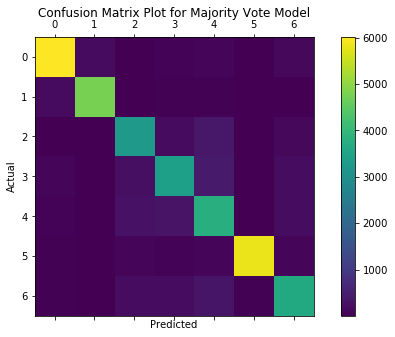

In [22]:
# Nice plot of confusion matrix
# Adjust size of confusion matrix by following code taken from StackOverflow
# https://stackoverflow.com/questions/43021762/matplotlib-how-to-change-figsize-for-matshow
plt.figure(figsize=(10,5))
plt.matshow(cm, fignum=1)

plt.title('Confusion Matrix Plot for Majority Vote Model')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

In [26]:
vote_prediction1 = eclf1.predict(X_test)
print(classification_report(vote_prediction1, y_test))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      6398
           1       0.94      0.96      0.95      5003
           3       0.82      0.79      0.80      4115
           6       0.77      0.80      0.78      4277
           7       0.81      0.73      0.77      5176
           8       0.94      0.98      0.96      5941
           9       0.82      0.82      0.82      4463

    accuracy                           0.87     35373
   macro avg       0.86      0.86      0.86     35373
weighted avg       0.87      0.87      0.87     35373



In [27]:
%%time
clf1d = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
clf2d = PassiveAggressiveClassifier()
clf3d = Perceptron(tol=1e-3, random_state=0)
clf4d = MultinomialNB()

eclf2 = VotingClassifier(estimators=[('sgd', clf1d), ('pac', clf2d), ('per', clf3d),('mnb',clf4d)], voting='hard')
eclf2.fit(X_train, y_train)
# evaluate accuracy of our model on test data
print("Majority Voting Classifier Score: {:.2f}".format(eclf2.score(X_test, y_test)))
print()

Majority Voting Classifier Score: 0.87

CPU times: user 9min 20s, sys: 28 s, total: 9min 48s
Wall time: 10min 21s


In [28]:
vote_prediction2 = eclf2.predict(X_test)
print(classification_report(vote_prediction2, y_test))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      6429
           1       0.94      0.95      0.95      5042
           3       0.82      0.80      0.81      4037
           6       0.77      0.80      0.78      4285
           7       0.80      0.73      0.77      5169
           8       0.95      0.98      0.97      5993
           9       0.81      0.82      0.82      4418

    accuracy                           0.87     35373
   macro avg       0.86      0.86      0.86     35373
weighted avg       0.87      0.87      0.87     35373

